In [1]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show()

24/05/12 15:11:37 WARN Utils: Your hostname, shukus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.15 instead (on interface en0)
24/05/12 15:11:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 15:11:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 15:11:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/12 15:11:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)



+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|    1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.7|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.7|
|         1|    pod save america|[10.0,-0.01585099...|  0.8|
|         1|    pod save america|[10.0,-0.01585099...|  0.1|
|         1|    pod save america|[10.0,-0.01585099...|  0.9|
|         1|    pod save

In [2]:
from pyspark.sql.functions import rand

# shuffle
shuffled_df = assembled_df.repartition("features")  # 分区数根据数据大小和集群能力调整
shuffled_df = shuffled_df.orderBy(rand())

In [3]:
from pyspark.sql.functions import when, col
from pyspark.ml.classification import RandomForestClassifier

# Filter out rows where the label is exactly 0.5
shuffled_df = shuffled_df.filter(col("label") != 0.5)

# apply original transformation without needing the 'otherwise' clause
shuffled_df = shuffled_df.withColumn(
    "binary_label",
    when(col("label") > 0.5, 1).otherwise(0)
)
shuffled_df.show()

+----------+--------------------+--------------------+-----+------------+
|segment_id|podcast_name_cleaned|            features|label|binary_label|
+----------+--------------------+--------------------+-----+------------+
|        51|Common Sense with...|[15.0,-0.01201010...|  0.7|           1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|           0|
|       112|Stay Tuned with P...|[6.0,-0.051940165...|    1|           1|
|        53|FiveThirtyEight P...|[14.0,-0.01737330...|    0|           0|
|        78|    pod save america|[35.0,-0.02068750...|  0.9|           1|
|        29|    pod save america|[6.0,-0.011244099...|  0.1|           0|
|       130|         Steve Deace|[16.0,-0.00819332...|    0|           0|
|       130|         Steve Deace|[16.0,-0.00819332...|    1|           1|
|       110|     Today Explained|[11.0,-0.01412328...|  0.1|           0|
|        55|The Clay Travis a...|[0.0,-0.022040747...|  0.9|           1|
|       112|Stay Tuned with P...|[6.0,

In [4]:
# split data
train_data, test_data = shuffled_df.randomSplit([0.7, 0.3], seed=42)
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="binary_label")

# training model
lr_model = lr.fit(train_data)


24/05/12 15:11:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/05/12 15:11:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/12 15:11:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [5]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# prediction
predictions = lr_model.transform(test_data)

from pyspark.sql.functions import col

prediction_counts = predictions.groupBy("prediction").count()
# result
prediction_counts.show()
predictions.select("binary_label", "prediction", "probability").show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   93|
|       1.0|   95|
+----------+-----+

+------------+----------+----------------------------------------+
|binary_label|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |1.0       |[0.43609281753061385,0.5639071824693862]|
|0           |1.0       |[0.23539077201049455,0.7646092279895055]|
|1           |1.0       |[0.23539077201049455,0.7646092279895055]|
|1           |1.0       |[0.23539077201049455,0.7646092279895055]|
|1           |1.0       |[0.23539077201049455,0.7646092279895055]|
|0           |1.0       |[0.3763022696038735,0.6236977303961265] |
|0           |1.0       |[0.3763022696038735,0.6236977303961265] |
|1           |1.0       |[0.3763022696038735,0.6236977303961265] |
|0           |0.0       |[0.5627811045675775,0.43721889543242254]|
|0           |0.0       |[0.5627811045675775,0.43721889543242254]|
|1           |

In [6]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="binary_label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Area Under ROC: {auc}")

Area Under ROC: 0.42898600204848075


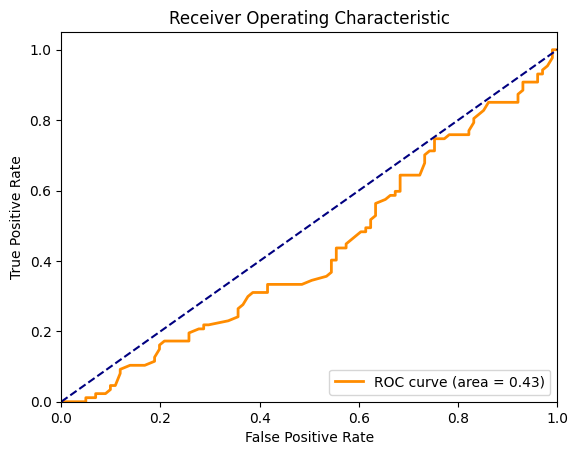

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Retrieve labels and prediction probabilities
labels_and_probs = predictions.select("binary_label", "probability").rdd.map(lambda row: (float(row[0]), float(row[1][1]))).collect()
labels, scores = zip(*labels_and_probs)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

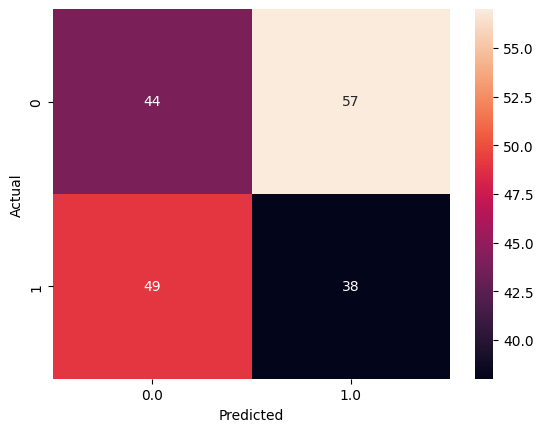

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = predictions.select("binary_label", "prediction").toPandas()

# Generate the confusion matrix
confusion_matrix = pd.crosstab(pandas_df['binary_label'], pandas_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Use seaborn to plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [9]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import DoubleType

# Define a UDF to extract elements from a vector
def extract_probability_element(prob_vector, index):
    return float(prob_vector.values[index])

# Register the UDF
extract_probability_udf = udf(extract_probability_element, DoubleType())

# Use the UDF to extract Biden and Trump probabilities
predictions = predictions.withColumn("prob_biden", extract_probability_udf(col("probability"), lit(0)))
predictions = predictions.withColumn("prob_trump", extract_probability_udf(col("probability"), lit(1)))
predictions.select("prob_biden", "prob_trump").show()
# Now calculate the averages
average_probs = predictions.agg(
    {"prob_biden": "avg", "prob_trump": "avg"}
).collect()[0]

avg_prob_biden = average_probs["avg(prob_biden)"]
avg_prob_trump = average_probs["avg(prob_trump)"]

print(f"Average Biden win probability: {avg_prob_biden*100:.2f}%")
print(f"Average Trump win probability: {avg_prob_trump*100:.2f}%")

+-------------------+-------------------+
|         prob_biden|         prob_trump|
+-------------------+-------------------+
|0.43609281753061385| 0.5639071824693862|
|0.23539077201049455| 0.7646092279895055|
|0.23539077201049455| 0.7646092279895055|
|0.23539077201049455| 0.7646092279895055|
|0.23539077201049455| 0.7646092279895055|
| 0.3763022696038735| 0.6236977303961265|
| 0.3763022696038735| 0.6236977303961265|
| 0.3763022696038735| 0.6236977303961265|
| 0.5627811045675775|0.43721889543242254|
| 0.5627811045675775|0.43721889543242254|
| 0.5627811045675775|0.43721889543242254|
| 0.4016593866989502| 0.5983406133010498|
| 0.4016593866989502| 0.5983406133010498|
| 0.4016593866989502| 0.5983406133010498|
| 0.3423822363410099| 0.6576177636589902|
| 0.3423822363410099| 0.6576177636589902|
| 0.3423822363410099| 0.6576177636589902|
| 0.2411204946031075| 0.7588795053968925|
| 0.2411204946031075| 0.7588795053968925|
| 0.2411204946031075| 0.7588795053968925|
+-------------------+-------------

Average Biden win probability: 51.02%
Average Trump win probability: 48.98%


In [10]:
spark.stop()